In [1]:
from google.colab import drive
drive.mount('/content/drive')



#datasets = load_data(user_ids, path_to_data)
#train_on_clients(datasets)

Mounted at /content/drive


In [2]:


import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
path_to_data_X = 'drive/MyDrive/Colab Notebooks/train_X.npy'
path_to_data_y = 'drive/MyDrive/Colab Notebooks/train_y.npy'
path_to_data_test_X = 'drive/MyDrive/Colab Notebooks/test_X.npy'
path_to_data_test_y = 'drive/MyDrive/Colab Notebooks/test_y.npy'
datasets_X = np.load(path_to_data_X, allow_pickle=True)
datasets_y = np.load(path_to_data_y, allow_pickle=True)
test_X = np.load(path_to_data_test_X, allow_pickle=True)
test_y = np.load(path_to_data_test_y, allow_pickle=True)

In [8]:
from sklearn.model_selection import train_test_split
training_X, valid_X, training_y, valid_y = train_test_split(datasets_X, datasets_y, test_size=0.2, random_state=42)

In [9]:
datasets = {}
datasets['images'] = datasets_X
datasets['labels'] = datasets_y
test_datasets = {}
test_datasets['images'] = test_X
test_datasets['labels'] = test_y
train_datasets = {}
train_datasets['images'] = training_X
train_datasets['labels'] = training_y
val_datasets = {}
val_datasets['images'] = valid_X
val_datasets['labels'] = valid_y


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self,act):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        if act == 'RELU':
          self.relu = nn.ReLU()
        elif act == 'sigmoid':
          self.relu = nn.Sigmoid()
        else:
          self.relu = nn.Tanh()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Create a model instance
# model = SimpleNN()


In [4]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [5]:
from sklearn.metrics import f1_score

In [ ]:
def evaluate_fitness(chromosome, datasets, test_datasets, num_epochs=20):
    mini_batch_size, activation_function = chromosome
    lists = ['RELU', 'sigmoid', 'tanh']
    model = SimpleNN(lists[activation_function])  # Define your model architecture here
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Modify your train_loader to use the new mini_batch_size
    #train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)

    for epoch in range(num_epochs):
        # Train your model for one epoch
        # ...
        models = []
        tmp_loss = 0
        tmp_accuracy = 0

        data = torch.tensor(datasets['images'])
        target = torch.tensor(datasets['labels']).type(torch.LongTensor)
        for batch in iterate_minibatches(data, target, mini_batch_size, shuffle=True):
      # Split batch to get batch data and labels
          batch_data, batch_labels = batch

        # Forward pass
          outputs = model(batch_data)
          loss = criterion(outputs, batch_labels)

          #Backward pass and optimization
          optimizer.zero_grad()  # Clear existing gradients
          loss.backward()        # Compute gradients
          optimizer.step()       # Update parameters

    # Evaluate on validation set
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        # Calculate F1 score on validation set
        # ...
        data = torch.tensor(test_datasets['images'])
        target = torch.tensor(test_datasets['labels']).type(torch.LongTensor)
        true_labels.extend(target.tolist())
        output = model(data)
        predictions.extend(torch.argmax(output,dim=1).tolist())
        val_f1_score = f1_score(true_labels, predictions, average='macro')

    return val_f1_score


In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import f1_score

def black_box_function(batch_size, activation_param):
    # Convert continuous parameters to discrete as needed
    chromosome = (int(batch_size),int(activation_param))

    # Example: Using the activation_param in a custom activation function
    # model = build_model(activation_param)  # Define your model-building function

    # Train your model on the training set
    # ...

    # Evaluate on the validation set
    f1 = evaluate_fitness(chromosome, train_datasets, val_datasets) # Assume evaluate() returns the F1 score
    return f1


In [ ]:
pbounds = {
    'batch_size': (16, 1024),  # Example range for batch size
    'activation_param': (0,2)  # Example range for a custom activation parameter
}

In [ ]:

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=2,  # Number of random steps to start the optimization
    n_iter=200,       # Number of optimization steps
)

print(optimizer.max)

lists = ['RELU', 'sigmoid', 'tanh']
best_params = optimizer.max['params']
print(f"Best batch size: {int(best_params['batch_size'])}")
print(f"Best activation parameter: {lists[int(best_params['activation_param'])]}")

# Now, train your final model using these best parameters
# ...
chromosome = (int(best_params['batch_size']), int(best_params['activation_param']))
evaluate_fitness(chromosome, datasets, test_datasets)

|   iter    |  target   | activa... | batch_... |
-------------------------------------------------
| 1         | 0.2979    | 0.834     | 742.1     |
| 2         | 0.4797    | 0.0002287 | 320.8     |
| 3         | 0.5615    | 0.0879    | 322.1     |
| 4         | 0.5852    | 0.06365   | 324.3     |
| 5         | 0.0732    | 1.891     | 329.5     |
| 6         | 0.2246    | 0.03646   | 1.022e+03 |
| 7         | 0.667     | 0.7913    | 178.7     |
| 8         | 0.1396    | 1.154     | 182.8     |
| 9         | 0.6293    | 0.782     | 176.4     |
| 10        | 0.06734   | 1.721     | 171.7     |
| 11        | 0.1748    | 1.96      | 177.6     |
| 12        | 0.6575    | 0.5427    | 179.1     |
| 13        | 0.673     | 0.4403    | 177.7     |
| 14        | 0.06324   | 1.863     | 323.0     |
| 15        | 0.585     | 0.1019    | 175.5     |
| 16        | 0.4683    | 0.19      | 326.0     |
| 17        | 0.4892    | 0.18      | 317.4     |
| 18        | 0.08476   | 1.81      | 315.8     |


0.8570409626457165

In [12]:

def train_fitness(chromosome, datasets, test_datasets, num_epochs=200):
    mini_batch_size, activation_function = chromosome
    lists = ['RELU', 'sigmoid', 'tanh']
    model = SimpleNN('RELU')  # Define your model architecture here
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Modify your train_loader to use the new mini_batch_size
    #train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)

    f1 = []
    for epoch in range(num_epochs):
        # Train your model for one epoch
        # ...
        models = []
        tmp_loss = 0
        tmp_accuracy = 0
        predictions = []
        true_labels = []

        data = torch.tensor(datasets['images'])
        target = torch.tensor(datasets['labels']).type(torch.LongTensor)
        for batch in iterate_minibatches(data, target, mini_batch_size, shuffle=True):
      # Split batch to get batch data and labels
          batch_data, batch_labels = batch

        # Forward pass
          outputs = model(batch_data)
          loss = criterion(outputs, batch_labels)
          pred = torch.argmax(outputs,dim=1)


          #Backward pass and optimization
          optimizer.zero_grad()  # Clear existing gradients
          loss.backward()        # Compute gradients
          optimizer.step()       # Update parameters
          with torch.no_grad():
            predictions.extend(torch.argmax(outputs,dim=1).tolist())
            true_labels.extend(batch_labels.tolist())
        f1.append(f1_score(true_labels, predictions, average='macro'))

    # Evaluate on validation set
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        # Calculate F1 score on validation set
        # ...
        data = torch.tensor(test_datasets['images'])
        target = torch.tensor(test_datasets['labels']).type(torch.LongTensor)
        true_labels.extend(target.tolist())
        output = model(data)
        predictions.extend(torch.argmax(output,dim=1).tolist())
        val_f1_score = f1_score(true_labels, predictions, average='macro')

    return f1,val_f1_score
chromosome = (17,'RELU')
f1, val_f1 = train_fitness(chromosome, datasets, test_datasets)

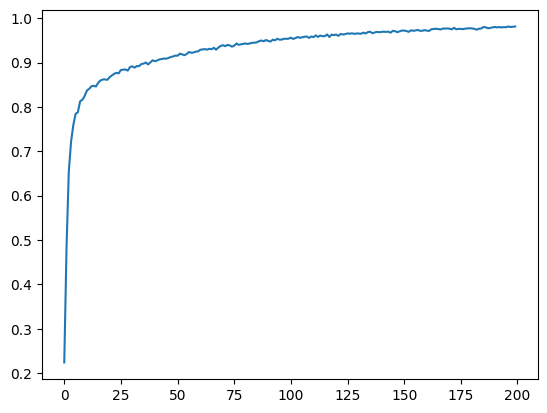

In [13]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.arange(len(f1))

plt.plot(xpoints, f1)
plt.show()

In [14]:
val_f1

0.9668201493109102